In [20]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tqdm import tqdm
import textwrap
from openai import OpenAI
from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer, InputExample, losses
from torch.utils.data import DataLoader
from sklearn.manifold import TSNE
from pathlib import Path
import torch
import random

os.environ["OPENAI_API_KEY"] = "YOUR_OPENAI_API_KEY"
client = OpenAI()

Train/Test Split

In [21]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(1256178)

In [22]:
bullets_df = pd.read_csv("bullet_jd.csv")
q_df = pd.read_csv("generated_question.csv")

In [29]:
MY_SEED = 1256178
set_seed(MY_SEED)

bullets_df = pd.read_csv("bullet_jd.csv")
q_df = pd.read_csv("generated_question.csv")

# random_state=MY_SEED
train_bullet_ids, test_bullet_ids = train_test_split(
    bullets_df["bullet_id"].unique(),
    test_size=0.2,
    random_state=MY_SEED
)

bullets_df_train = bullets_df[bullets_df["bullet_id"].isin(train_bullet_ids)]
q_df_train       = q_df[q_df["bullet_id"].isin(train_bullet_ids)]

bullets_df_test  = bullets_df[bullets_df["bullet_id"].isin(test_bullet_ids)]
q_df_test        = q_df[q_df["bullet_id"].isin(test_bullet_ids)]

In [30]:
def build_finetune_pairs_jdq_to_bullet(bullets_df: pd.DataFrame,
                                       q_df: pd.DataFrame) -> pd.DataFrame:
    # 1. 合併 question 資訊到 bullet 上
    merged = q_df.merge(
        bullets_df,
        on=["bullet_id", "job_id"],
        suffixes=("_q", "_b")
    )

    # 2. 組 query_text：JD + 問題
    merged["query_text"] = (
        "JOB DESCRIPTION:\n" +
        merged["job_description"].astype(str) +
        "\n\nINTERVIEW QUESTION:\n" +
        merged["question"].astype(str)
    )

    pairs = merged[["query_text", "bullet"]].copy()
    print("Total fine-tuning pairs:", len(pairs))
    return pairs

# ★ 執行這一行來產生 train_pairs ★
train_pairs = build_finetune_pairs_jdq_to_bullet(bullets_df_train, q_df_train)

Total fine-tuning pairs: 4965


## Base model: sentencetransformer all-MiniLM-L6-v2 & all-mpnet-base-v2

In [26]:
from sentence_transformers import SentenceTransformer, InputExample, losses, evaluation, util
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os

# 定義兩個模型的名稱
MODEL_MINI = "sentence-transformers/all-MiniLM-L6-v2"
MODEL_MPNET = "sentence-transformers/all-mpnet-base-v2"

In [27]:
def train_and_evaluate_model(
    train_pairs_df,
    val_bullets_df,
    val_q_df,
    model_name,
    output_path,
    epochs=10,
    batch_size=32
):
    """
    通用訓練函數：
    1. 載入指定模型
    2. 準備訓練與驗證資料
    3. 執行訓練 (包含 Warmup, Evaluator, Save Best Model)
    4. 回傳訓練好的模型與 Loss 紀錄
    """

    print(f"\n{'='*20}\n正在訓練模型: {model_name}\n{'='*20}")

    # 1. 初始化模型
    model = SentenceTransformer(model_name, device=DEVICE)

    # 2. 準備訓練資料
    train_examples = [
        InputExample(texts=[row["query_text"], row["bullet"]])
        for _, row in train_pairs_df.iterrows()
    ]
    train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=batch_size)

    # 3. 準備驗證器 (Evaluator) - 用來存最佳模型
    # 需要建立 job_id -> description 對照表來組 query
    job_id2desc = val_bullets_df.set_index("job_id")["job_description"].to_dict()

    queries = {}
    corpus = {}
    relevant_docs = {}

    # 建立 Corpus (所有可能的答案)
    for _, row in val_bullets_df.iterrows():
        corpus[str(row["bullet_id"])] = row["bullet"]

    # 建立 Queries 與 標準答案
    for idx, row in val_q_df.iterrows():
        q_id = str(idx)
        bullet_id = str(row["bullet_id"])

        # 組合 Query: JD + Question
        jd_text = job_id2desc.get(row["job_id"], "")
        full_query = f"JOB DESCRIPTION:\n{jd_text}\n\nINTERVIEW QUESTION:\n{row['question']}"

        queries[q_id] = full_query
        relevant_docs[q_id] = set([bullet_id])

    evaluator = evaluation.InformationRetrievalEvaluator(
        queries=queries,
        corpus=corpus,
        relevant_docs=relevant_docs,
        name=os.path.basename(output_path),
        show_progress_bar=False,
        score_functions={'cos_sim': util.cos_sim}
    )

    # 4. 定義 Loss 並加入紀錄功能
    loss_history = []
    class LoggingMNRLoss(losses.MultipleNegativesRankingLoss):
        def __init__(self, model, buffer):
            super().__init__(model)
            self.buffer = buffer
        def forward(self, sentence_features, labels=None):
            loss = super().forward(sentence_features, labels)
            self.buffer.append(loss.item())
            return loss

    train_loss = LoggingMNRLoss(model, loss_history)

    # 5. 開始訓練
    warmup_steps = int(len(train_dataloader) * epochs * 0.1)

    model.fit(
        train_objectives=[(train_dataloader, train_loss)],
        epochs=epochs,
        warmup_steps=warmup_steps,
        evaluator=evaluator,
        evaluation_steps=0,     # 每 epoch 結束測一次
        save_best_model=True,   # ★ 只存最好的
        output_path=output_path,
        show_progress_bar=True
    )

    # 載入最佳模型
    best_model = SentenceTransformer(output_path)
    steps_per_epoch = len(train_dataloader)

    return best_model, loss_history, steps_per_epoch

In [31]:
# --- 訓練模型 A: MiniLM (輕量級) ---
model_mini_ft, loss_mini, steps_mini = train_and_evaluate_model(
    train_pairs_df=train_pairs,
    val_bullets_df=bullets_df_test,
    val_q_df=q_df_test,
    model_name=MODEL_MINI,
    output_path="../models/ft_miniLM_v2",
    epochs=10,
    batch_size=32
)

# --- 訓練模型 B: MPNet (重量級) ---
model_mpnet_ft, loss_mpnet, steps_mpnet = train_and_evaluate_model(
    train_pairs_df=train_pairs,
    val_bullets_df=bullets_df_test,
    val_q_df=q_df_test,
    model_name=MODEL_MPNET,
    output_path="../models/ft_mpnet_v2",
    epochs=10, # 雖然 MPNet 比較慢，但為了準確度建議還是跑 5-10 輪
    batch_size=16 # MPNet 比較吃顯存，如果爆記憶體(OOM)請改回 16，不然維持 32
)


正在訓練模型: sentence-transformers/all-MiniLM-L6-v2


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 3


wandb: You chose "Don't visualize my results"


wandb: Detected [openai] in use.
wandb: Use W&B Weave for improved LLM call tracing. Install Weave with `pip install weave` then add `import weave` to the top of your script.
wandb: For more information, check out the docs at: https://weave-docs.wandb.ai/


Step,Training Loss,Validation Loss,Ft Minilm V2 Cos Sim Accuracy@1,Ft Minilm V2 Cos Sim Accuracy@3,Ft Minilm V2 Cos Sim Accuracy@5,Ft Minilm V2 Cos Sim Accuracy@10,Ft Minilm V2 Cos Sim Precision@1,Ft Minilm V2 Cos Sim Precision@3,Ft Minilm V2 Cos Sim Precision@5,Ft Minilm V2 Cos Sim Precision@10,Ft Minilm V2 Cos Sim Recall@1,Ft Minilm V2 Cos Sim Recall@3,Ft Minilm V2 Cos Sim Recall@5,Ft Minilm V2 Cos Sim Recall@10,Ft Minilm V2 Cos Sim Ndcg@10,Ft Minilm V2 Cos Sim Mrr@10,Ft Minilm V2 Cos Sim Map@100
156,No log,No log,0.353462,0.511272,0.574074,0.644928,0.353462,0.170424,0.114815,0.064493,0.353462,0.511272,0.574074,0.644928,0.493436,0.445530,0.454568
312,No log,No log,0.365539,0.521739,0.590177,0.666667,0.365539,0.173913,0.118035,0.066667,0.365539,0.521739,0.590177,0.666667,0.511467,0.462327,0.471882
468,No log,No log,0.376006,0.544283,0.610306,0.684380,0.376006,0.181428,0.122061,0.068438,0.376006,0.544283,0.610306,0.684380,0.525064,0.474520,0.483811
500,0.909100,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log
624,0.909100,No log,0.386473,0.556361,0.620773,0.687601,0.386473,0.185454,0.124155,0.068760,0.386473,0.556361,0.620773,0.687601,0.534378,0.485547,0.494972
780,0.909100,No log,0.388889,0.553945,0.621578,0.700483,0.388889,0.184648,0.124316,0.070048,0.388889,0.553945,0.621578,0.700483,0.539479,0.488564,0.497554
936,0.909100,No log,0.389694,0.553140,0.618357,0.704509,0.389694,0.184380,0.123671,0.070451,0.389694,0.553140,0.618357,0.704509,0.540695,0.488978,0.497981
1000,0.459400,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log
1092,0.459400,No log,0.379227,0.557166,0.629630,0.702899,0.379227,0.185722,0.125926,0.070290,0.379227,0.557166,0.629630,0.702899,0.537263,0.484620,0.493904
1248,0.459400,No log,0.382448,0.557971,0.623188,0.708535,0.382448,0.185990,0.124638,0.070853,0.382448,0.557971,0.623188,0.708535,0.539515,0.486136,0.495163



正在訓練模型: sentence-transformers/all-mpnet-base-v2


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Step,Training Loss,Validation Loss,Ft Mpnet V2 Cos Sim Accuracy@1,Ft Mpnet V2 Cos Sim Accuracy@3,Ft Mpnet V2 Cos Sim Accuracy@5,Ft Mpnet V2 Cos Sim Accuracy@10,Ft Mpnet V2 Cos Sim Precision@1,Ft Mpnet V2 Cos Sim Precision@3,Ft Mpnet V2 Cos Sim Precision@5,Ft Mpnet V2 Cos Sim Precision@10,Ft Mpnet V2 Cos Sim Recall@1,Ft Mpnet V2 Cos Sim Recall@3,Ft Mpnet V2 Cos Sim Recall@5,Ft Mpnet V2 Cos Sim Recall@10,Ft Mpnet V2 Cos Sim Ndcg@10,Ft Mpnet V2 Cos Sim Mrr@10,Ft Mpnet V2 Cos Sim Map@100
311,No log,No log,0.457327,0.626409,0.690821,0.766506,0.457327,0.208803,0.138164,0.076651,0.457327,0.626409,0.690821,0.766506,0.607799,0.557483,0.565295
500,0.421200,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log
622,0.421200,No log,0.479066,0.648953,0.710950,0.792271,0.479066,0.216318,0.142190,0.079227,0.479066,0.648953,0.710950,0.792271,0.631184,0.580232,0.587436
933,0.421200,No log,0.485507,0.676329,0.732689,0.808374,0.485507,0.225443,0.146538,0.080837,0.485507,0.676329,0.732689,0.808374,0.645037,0.592968,0.599871
1000,0.180100,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log
1244,0.180100,No log,0.486312,0.664251,0.719807,0.807568,0.486312,0.221417,0.143961,0.080757,0.486312,0.664251,0.719807,0.807568,0.642856,0.590710,0.597786
1500,0.084200,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log
1555,0.084200,No log,0.490338,0.665862,0.729469,0.813205,0.490338,0.221954,0.145894,0.081320,0.490338,0.665862,0.729469,0.813205,0.647323,0.594734,0.601586
1866,0.084200,No log,0.486312,0.680354,0.754428,0.827697,0.486312,0.226785,0.150886,0.082770,0.486312,0.680354,0.754428,0.827697,0.655125,0.600044,0.605972
2000,0.055000,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log


## Evaluation & Plot


In [34]:
def evaluate_jd_plus_question_to_bullet(model: SentenceTransformer,
                                        bullets_df: pd.DataFrame,
                                        q_df: pd.DataFrame,
                                        ks=(1, 3, 5, 10)):
    """
    Evaluate retrieval for the true use case:
    Given (job_description + interview question) as query,
    can the model retrieve the correct bullet from all bullets?

    bullets_df: 包含至少 ['bullet_id', 'job_id', 'bullet', 'job_description']
    q_df:       包含至少 ['bullet_id', 'job_id', 'question']
    """

    # 1. 準備所有 candidate bullets 的 embedding（一次算好）
    all_bullets = bullets_df["bullet"].tolist()
    all_bullet_ids = bullets_df["bullet_id"].tolist()
    bullet_embs = model.encode(
        all_bullets,
        convert_to_tensor=True,
        show_progress_bar=True
    )

    # 2. 建 job_id -> job_description 對應表（用來組 query）
    job_id2desc = (
        bullets_df[["job_id", "job_description"]]
        .drop_duplicates()
        .set_index("job_id")["job_description"]
        .to_dict()
    )

    hits = {k: 0 for k in ks}
    precision = {k: 0.0 for k in ks}

    # 3. 逐行 query： (JD + question) -> retrieve bullet
    for _, row in tqdm(q_df.iterrows(),
                       total=len(q_df),
                       desc="Eval (JD + question) -> bullet"):
        q_text = row["question"]
        job_id = row["job_id"]
        true_bullet_id = row["bullet_id"]

        # 安全拿到對應的 JD
        jd_text = job_id2desc.get(job_id, "")

        # 把 JD + question 組成一個 query
        query_text = f"Job description:\n{jd_text}\n\nInterview question:\n{q_text}"

        q_emb = model.encode(query_text, convert_to_tensor=True)
        cos_scores = util.cos_sim(q_emb, bullet_embs)[0]   # shape: (n_bullets,)

        # 取 top-k（完全用 torch，不轉 numpy）
        top_indices_tensor = torch.topk(cos_scores, k=max(ks)).indices.cpu()
        top_indices = top_indices_tensor.tolist()  # 變成 Python list[int]
        top_bullet_ids = [all_bullet_ids[i] for i in top_indices]

        # 統計 Hit@k / Precision@k
        for k in ks:
            topk_ids = top_bullet_ids[:k]
            if true_bullet_id in topk_ids:
                hits[k] += 1
                precision[k] += 1.0 / k
            else:
                precision[k] += 0.0

    n_queries = len(q_df)
    results = {}
    for k in ks:
        results[k] = {
            "Hit@k": hits[k] / n_queries,
            "Precision@k": precision[k] / n_queries
        }

    print("=== Retrieval: (JD + question) -> bullet ===")
    for k in ks:
        print(f"k={k}: Hit@k={results[k]['Hit@k']:.4f}, "
              f"Precision@k={results[k]['Precision@k']:.4f}")
    return results

In [36]:
print("=== Final Evaluation Results ===")

# 1. Baseline MiniLM (Pre-trained only)
print("\n[1] Evaluating Baseline MiniLM...")
base_mini = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
res_base_mini = evaluate_jd_plus_question_to_bullet(base_mini, bullets_df_test, q_df_test)

# 2. Baseline MPNet (Pre-trained only)
print("\n[2] Evaluating Baseline MPNet...")
base_mpnet = SentenceTransformer("sentence-transformers/all-mpnet-base-v2")
res_base_mpnet = evaluate_jd_plus_question_to_bullet(base_mpnet, bullets_df_test, q_df_test)

# 3. Finetuned MiniLM (Your trained lightweight model)
print("\n[3] Evaluating Finetuned MiniLM...")
res_ft_mini = evaluate_jd_plus_question_to_bullet(model_mini_ft, bullets_df_test, q_df_test)

# 4. Finetuned MPNet (Your trained heavyweight model)
print("\n[4] Evaluating Finetuned MPNet...")
res_ft_mpnet = evaluate_jd_plus_question_to_bullet(model_mpnet_ft, bullets_df_test, q_df_test)

# Create comparison table
import pandas as pd

comparison_rows = []
for k in [1, 3, 5, 10]:
    comparison_rows.append({
        "Top-k": k,
        "Base_MiniLM": f"{res_base_mini[k]['Hit@k']:.1%}",
        "Base_MPNet": f"{res_base_mpnet[k]['Hit@k']:.1%}",
        "FT_MiniLM": f"{res_ft_mini[k]['Hit@k']:.1%}",
        "FT_MPNet": f"{res_ft_mpnet[k]['Hit@k']:.1%}"
    })

df_result = pd.DataFrame(comparison_rows)
print("\n=== Hit Rate Comparison ===")
display(df_result)

=== Final Evaluation Results ===

[1] Evaluating Baseline MiniLM...


Batches:   0%|          | 0/39 [00:00<?, ?it/s]

Eval (JD + question) -> bullet: 100%|██████████| 1242/1242 [00:11<00:00, 107.25it/s]


=== Retrieval: (JD + question) -> bullet ===
k=1: Hit@k=0.2150, Precision@k=0.2150
k=3: Hit@k=0.3196, Precision@k=0.1065
k=5: Hit@k=0.3688, Precision@k=0.0738
k=10: Hit@k=0.4436, Precision@k=0.0444

[2] Evaluating Baseline MPNet...


Batches:   0%|          | 0/39 [00:00<?, ?it/s]

Eval (JD + question) -> bullet: 100%|██████████| 1242/1242 [00:37<00:00, 33.02it/s]

=== Retrieval: (JD + question) -> bullet ===
k=1: Hit@k=0.2158, Precision@k=0.2158
k=3: Hit@k=0.3229, Precision@k=0.1076
k=5: Hit@k=0.4018, Precision@k=0.0804
k=10: Hit@k=0.4944, Precision@k=0.0494

[3] Evaluating Finetuned MiniLM...


Batches:   0%|          | 0/39 [00:00<?, ?it/s]

Eval (JD + question) -> bullet: 100%|██████████| 1242/1242 [00:11<00:00, 106.94it/s]

=== Retrieval: (JD + question) -> bullet ===
k=1: Hit@k=0.3897, Precision@k=0.3897
k=3: Hit@k=0.5531, Precision@k=0.1844
k=5: Hit@k=0.6184, Precision@k=0.1237
k=10: Hit@k=0.7045, Precision@k=0.0705

[4] Evaluating Finetuned MPNet...


Batches:   0%|          | 0/39 [00:00<?, ?it/s]

Eval (JD + question) -> bullet: 100%|██████████| 1242/1242 [00:37<00:00, 32.98it/s]

=== Retrieval: (JD + question) -> bullet ===
k=1: Hit@k=0.4976, Precision@k=0.4976
k=3: Hit@k=0.6997, Precision@k=0.2332
k=5: Hit@k=0.7528, Precision@k=0.1506
k=10: Hit@k=0.8325, Precision@k=0.0833

=== Hit Rate Comparison ===


,Top-k,Base_MiniLM,Base_MPNet,FT_MiniLM,FT_MPNet
0,1,21.5%,21.6%,39.0%,49.8%
1,3,32.0%,32.3%,55.3%,70.0%
2,5,36.9%,40.2%,61.8%,75.3%
3,10,44.4%,49.4%,70.5%,83.3%


---

Generating t-SNE visualizations... (MPNet models may take a moment)
Processing model: Baseline MiniLM...


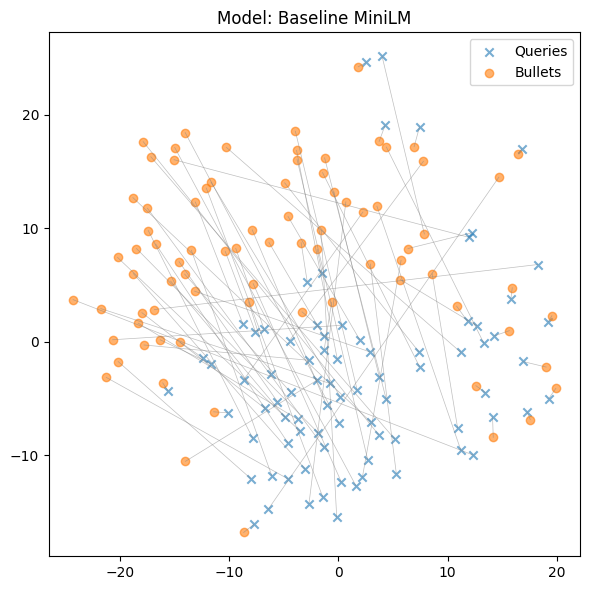

Processing model: Baseline MPNet...


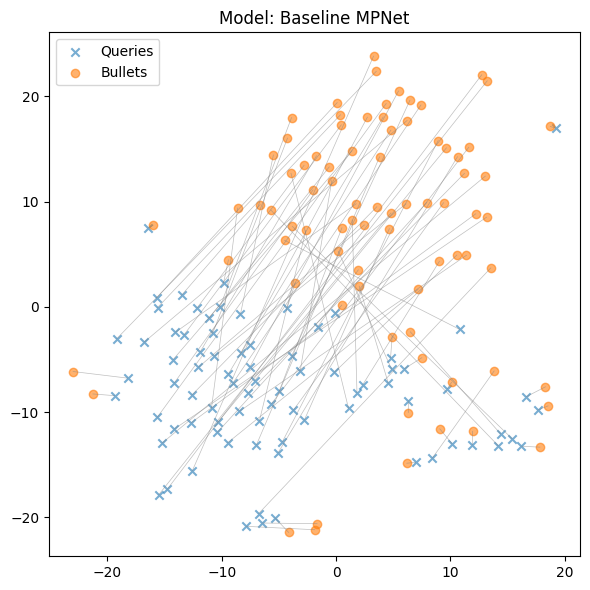

Processing model: Finetuned MiniLM...


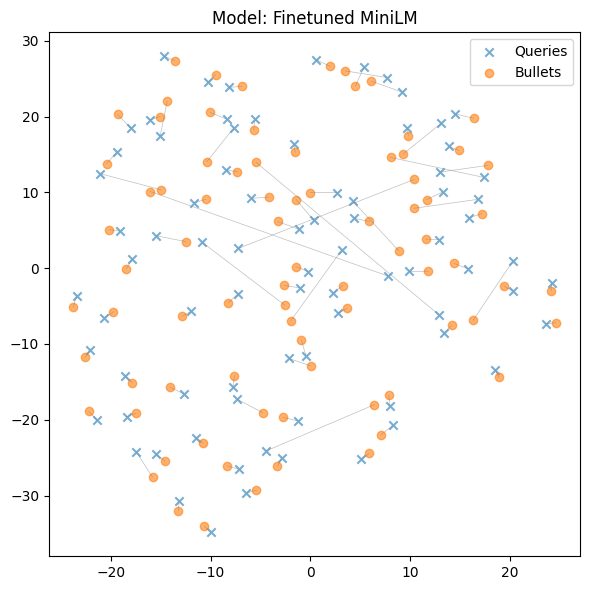

Processing model: Finetuned MPNet...


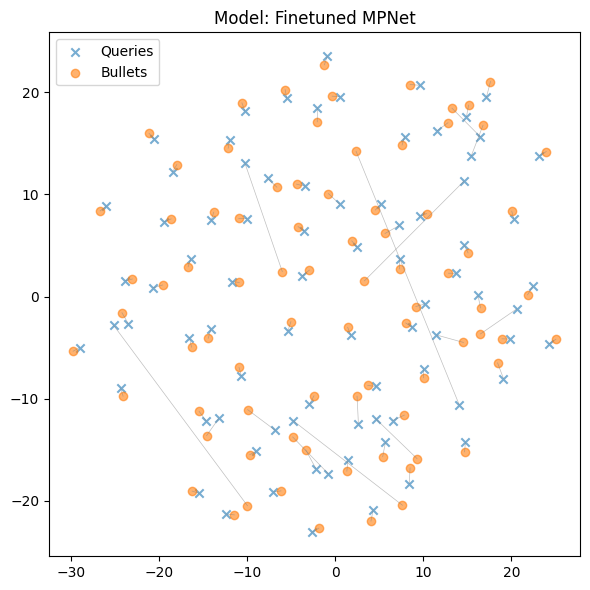

In [38]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
import torch
from sentence_transformers import SentenceTransformer

# 1. Prepare Data: Sample N_VIS test pairs for visualization
N_VIS = 80
# Sample 80 random questions from the test set
vis_q_df = q_df_test.sample(n=N_VIS, random_state=42).copy()

# Merge to get text for JD and Bullets
vis_merged = vis_q_df.merge(
    bullets_df_test,
    on=["bullet_id", "job_id"],
    suffixes=("_q", "_b")
)

# Prepare lists of texts: Queries (JD + Question) and Targets (Bullets)
texts_query = (
    "JOB DESCRIPTION:\n" +
    vis_merged["job_description"].astype(str) +
    "\n\nINTERVIEW QUESTION:\n" +
    vis_merged["question"].astype(str)
).tolist()

texts_bullet = vis_merged["bullet"].astype(str).tolist()

# 2. Define the four models to compare
# We load the baselines from scratch.
# We assume 'model_mini_ft' and 'model_mpnet_ft' are already trained and in memory.
models_map = {
    "Baseline MiniLM": SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2"),
    "Baseline MPNet":  SentenceTransformer("sentence-transformers/all-mpnet-base-v2"),
    "Finetuned MiniLM": model_mini_ft,
    "Finetuned MPNet":  model_mpnet_ft
}

# 3. Define the plotting function
def plot_embedding_2d(query_2d, bullet_2d, title):
    plt.figure(figsize=(6, 6))

    # Plot Queries (Blue X)
    plt.scatter(query_2d[:, 0], query_2d[:, 1], marker="x", alpha=0.6, label="Queries")

    # Plot Bullets (Orange O)
    plt.scatter(bullet_2d[:, 0], bullet_2d[:, 1], marker="o", alpha=0.6, label="Bullets")

    # Draw lines connecting each Query to its correct Bullet
    # Shorter lines indicate better model performance
    for i in range(len(query_2d)):
        plt.plot(
            [query_2d[i, 0], bullet_2d[i, 0]],
            [query_2d[i, 1], bullet_2d[i, 1]],
            color="gray", linewidth=0.5, alpha=0.5
        )

    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

# 4. Generate plots for each model
print("Generating t-SNE visualizations... (MPNet models may take a moment)")

for name, model in models_map.items():
    print(f"Processing model: {name}...")

    # A. Compute Embeddings
    # We use convert_to_tensor=False to get numpy arrays directly
    q_embs = model.encode(texts_query, convert_to_tensor=False, normalize_embeddings=True)
    b_embs = model.encode(texts_bullet, convert_to_tensor=False, normalize_embeddings=True)

    # B. Run t-SNE Dimensionality Reduction (384/768 dim -> 2 dim)
    # Stack them to project into the same 2D space
    combined_embs = np.vstack([q_embs, b_embs])

    tsne = TSNE(n_components=2, perplexity=15, random_state=42, init="random", learning_rate=200)
    combined_2d = tsne.fit_transform(combined_embs)

    # Split back into queries and bullets
    n = len(texts_query)
    q_2d = combined_2d[:n]
    b_2d = combined_2d[n:]

    # C. Plot
    plot_embedding_2d(q_2d, b_2d, title=f"Model: {name}")